In [26]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO
import cv2
import matplotlib.pyplot as plt
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from sklearn.metrics import f1_score, precision_score, recall_score, cohen_kappa_score, classification_report, confusion_matrix
from scipy.stats import rankdata
from numpy import linalg as LA
# import intel_extension_for_pytorch as ipex
from openvino.runtime.ie_api import CompiledModel
from typing import Union
import openvino as ov
import warnings
warnings.filterwarnings("ignore") 

%load_ext autotime
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
import numpy as np
device = 'cuda'
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.optim.lr_scheduler import MultiStepLR
import time
import os
plt.style.use('ggplot')
from tqdm import tqdm
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

from custom_utils import (
    Averager, 
    SaveBestModel, 
    save_model, 
    save_loss_plot,
    save_mAP
)

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 0 ns (started: 2024-05-06 10:15:02 +06:00)


In [27]:
classification_dictionary = {0:'person', 1: 'light', 2:'hydrant', 3:'sign', 4:'bike', 5:'car', 6:'skateboard',
                            7: 'motor', 8: 'bus', 9: 'stroller', 10: 'other', 11: 'truck', 12: 'negative', 13: 'train',
                            14: 'dog', 15: 'scooter'
                            }

time: 0 ns (started: 2024-05-06 10:15:02 +06:00)


In [28]:
class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.diction = {1: 0, 2: 4, 3: 5, 4: 7, 6: 8,  7:13, 8: 11, 10: 1, 
                   11: 2, 12: 3, 17: 14, 37: 6, 73: 9, 77: 15, 79: 10, 'scooter':15
                   }
    def __getitem__(self, index):
        linix = 1
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # print(coco_annotation)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        labels = []
        boxes = []
        for i in range(num_objs):
            linix = 2
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
#             xmin, ymin, xmax,ymax = xmin*(512/640), ymin*(512/512), xmax*(512/640),ymax*(512/512)
            boxes.append([xmin, ymin, xmax, ymax])
            try:
                labels.append(classification_dictionary[self.diction[coco_annotation[i]['category_id']]])
            except:
                labels.append(classification_dictionary[self.diction['scooter']])
 
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
#         labels = torch.as_tensor(labels, dtype=torch.int)
        # Labels (In my case, I only one class: target class or background)
#         labels = torch.ones((num_objs,), dtype=torch.int64)
        if linix == 1:
            boxes = torch.zeros(0,4)
            labels = torch.zeros((0,),dtype= torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

time: 0 ns (started: 2024-05-06 10:15:02 +06:00)


In [29]:
# torchvision.transforms.Resize((300,300)), torchvision.transforms.Grayscale(num_output_channels=1)
def get_transform():
    custom_transforms = [  torchvision.transforms.Grayscale(num_output_channels=1)# above is for: randomly selecting one for process
        ]
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

train_data_dir = 'images_thermal_train'
train_coco = 'images_thermal_train/coco.json'
val_train_dir = 'images_thermal_val'
val_coco = 'images_thermal_val/coco.json'
# create own Dataset

val_dataset = myOwnDataset(root=val_train_dir,
                          annotation=val_coco,
                          transforms=get_transform()
                          )

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

# # Batch size
# train_batch_size = 5
val_batch_size = 5
# train_dataset = train_dataset.to('cuda')
# val_dataset = val_dataset.to('cuda')

# # own DataLoader
# train_dataloader = torch.utils.data.DataLoader(train_dataset,
#                                           batch_size=train_batch_size,
#                                           shuffle=True,
#                                           collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=val_batch_size,
                                          shuffle=False,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.19s)
creating index...
index created!
time: 203 ms (started: 2024-05-06 10:15:03 +06:00)


In [46]:
def get_model_instance_segmentation(num_classes=16):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, rpn_pre_nms_top_n_test=50, rpn_post_nms_top_n_test=50, box_score_thresh = 0.1)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

len_dataloader = len(val_dataloader)


time: 0 ns (started: 2024-05-06 10:15:46 +06:00)


In [47]:
def validate(valid_data_loader, model):
    print('Validating')
    model.eval()
     
    # Initialize tqdm progress bar.
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    target = []
    preds = []
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.long().to(device) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            outputs = model(images, targets)

        # For mAP calculation using Torchmetrics.
        #####################################
        for i in range(len(images)):
            true_dict = dict()
            preds_dict = dict()
            true_dict['boxes'] = targets[i]['boxes'].detach().cpu()
            true_dict['labels'] = targets[i]['labels'].detach().cpu()
            preds_dict['boxes'] = outputs[i]['boxes'].detach().cpu()
            preds_dict['scores'] = outputs[i]['scores'].detach().cpu()
            preds_dict['labels'] = outputs[i]['labels'].detach().cpu()
            preds.append(preds_dict)
            target.append(true_dict)
        #####################################

    metric = MeanAveragePrecision(iou_type="bbox")
    metric.update(preds, target)
    metric_summary = metric.compute()
    print(metric_summary)
    return metric_summary

time: 0 ns (started: 2024-05-06 10:15:47 +06:00)


In [48]:
model = get_model_instance_segmentation(2)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

time: 656 ms (started: 2024-05-06 10:15:47 +06:00)


In [49]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

41076761

time: 16 ms (started: 2024-05-06 10:15:48 +06:00)


In [50]:
class Custom_predictor(torch.nn.Module):
    def __init__(self,in_channels,num_classes):
        super(Custom_predictor,self).__init__()
        self.cls_score = torch.nn.Linear(in_channels, num_classes)
        self.bbox_pred = torch.nn.Linear(in_channels, num_classes * 4)
        
        
    def forward(self,x):
        if x.dim() == 4:
            torch._assert(
                list(x.shape[2:]) == [1, 1],
                f"x has the wrong shape, expecting the last two dimensions to be [1,1] instead of {list(x.shape[2:])}",
            )
        x = x.flatten(start_dim=1)
#         scores = self.cls_score(x)
        #print(scores.size())
        bbox_deltas = self.bbox_pred(x)
        x = torch.zeros(len(bbox_deltas), 1)
        y = torch.ones(len(bbox_deltas),1)
        if bbox_deltas.is_cuda:
            scores = torch.cat((x, y), 1).to('cuda')
        else:
            scores = torch.cat((x, y), 1).to('cpu')
        return scores, bbox_deltas

time: 15 ms (started: 2024-05-06 10:15:48 +06:00)


In [51]:
count_parameters(model)

41076761

time: 0 ns (started: 2024-05-06 10:15:48 +06:00)


In [52]:
class Custom_predictor(torch.nn.Module):
    def __init__(self,in_channels,num_classes):
        super(Custom_predictor,self).__init__()
        self.cls_score = torch.nn.Linear(in_channels, num_classes)
        self.bbox_pred = torch.nn.Linear(in_channels, num_classes * 4)
        
        
    def forward(self,x):
        if x.dim() == 4:
            torch._assert(
                list(x.shape[2:]) == [1, 1],
                f"x has the wrong shape, expecting the last two dimensions to be [1,1] instead of {list(x.shape[2:])}",
            )
        x = x.flatten(start_dim=1)
#         scores = self.cls_score(x)
        #print(scores.size())
        bbox_deltas = self.bbox_pred(x)
        x = torch.zeros(len(bbox_deltas), 1)
        y = torch.ones(len(bbox_deltas),1)
        if bbox_deltas.is_cuda:
            scores = torch.cat((x, y), 1).to('cuda')
        else:
            scores = torch.cat((x, y), 1).to('cpu')
        return scores, bbox_deltas

time: 0 ns (started: 2024-05-06 10:15:48 +06:00)


In [53]:
in_features = model.roi_heads.box_head.fc7.out_features
#now we can add the custom predictor to the model
num_classes =2
model.roi_heads.box_predictor = Custom_predictor(in_features,num_classes)
checkpoint = torch.load(".\\detector\\best_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
model.roi_heads.box_predictor.cls_score = Identity()
count_parameters(model)
# model.roi_heads.box_head.fc7 =  torch.nn.Identity()

41074711

time: 296 ms (started: 2024-05-06 10:15:49 +06:00)


In [54]:
count_parameters(model)

41074711

time: 0 ns (started: 2024-05-06 10:15:49 +06:00)


In [55]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

time: 0 ns (started: 2024-05-06 10:15:50 +06:00)


In [56]:
# bbox = s[1][3]
# print(bbox)
# boxes = bbox['boxes']
# labels = bbox['labels']
# image = s[0][3]
# img_gray = np.float64(image)
# img_gray

time: 0 ns (started: 2024-05-06 10:15:54 +06:00)


tensor([[478., 124., 492., 157.],
        [519., 168., 539., 185.],
        [155., 149., 163., 177.],
        [513., 150., 563., 161.],
        [445., 193., 489., 317.],
        [286., 214., 312., 280.],
        [104., 238., 109., 248.],
        [188., 232., 195., 244.]])
['light', 'light', 'light', 'sign', 'person', 'person', 'person', 'person']


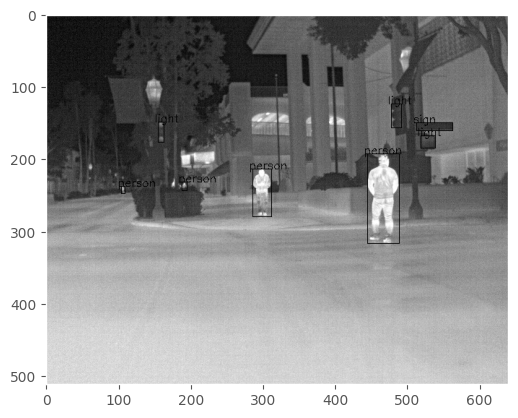

time: 235 ms (started: 2024-05-06 10:15:55 +06:00)


In [57]:
i = 150
img= val_dataset[i][0]
img2= val_dataset[i][0]
bbox = val_dataset[i][1]['boxes']
classes = val_dataset[i][1]['labels']
print(bbox)
print(classes)
for k,j in zip(bbox, classes):
    true_dict = dict()
    xmin, ymin, xmax, ymax = k

    pt1 = (int(xmin), int(ymin))
    pt2 = (int(xmax), int(ymax))

    bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(0,0,0),1)
    bnd_img = cv2.putText(
        bnd_img,
        str(j),
        (int(xmin)-5, int(ymin)),
        fontFace = cv2.FONT_HERSHEY_SIMPLEX,
        fontScale = 0.5,
        color = (0, 255, 255),
        thickness=1)
plt.grid(False)
plt.imshow(bnd_img, cmap = 'gray')

In [18]:
targets = []
for i in range(len(val_dataset)):
    
    f = open(".\\input\\ground-truth\\image_{0}.txt".format(i), "w")
    img= val_dataset[i][0]
    # img3= val_dataset[i][0]
    bbox = val_dataset[i][1]['boxes']
    classes = val_dataset[i][1]['labels']
    print(bbox)
    print(classes)
    for k,j in zip(bbox, classes):
        true_dict = dict()
        xmin, ymin, xmax, ymax = k
        
        pt1 = (int(xmin), int(ymin))
        pt2 = (int(xmax), int(ymax))
        
        bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(0,0,0),1)
        bnd_img = cv2.putText(
            bnd_img,
            str(j),
            (int(xmin), int(ymin) - 10),
            fontFace = cv2.FONT_HERSHEY_SIMPLEX,
            fontScale = 2,
            color = (0, 255, 255),
            thickness=2)
        
#     true_dict['boxes'] = bbox
#     true_dict['labels'] = classes
#     targets.append(true_dict)
        print(j)
        f.write(str(j)+" "+str(int(xmin))+" "+ str(int(ymin)) +" "+ str(int(xmax)) +" "+ str(int(ymax)))
        f.write("\n")
    f.close()

tensor([[237., 151., 261., 175.],
        [238., 175., 257., 180.],
        [ 84., 200.,  93., 211.],
        [237., 189., 338., 289.],
        [107., 203., 176., 255.]])
['sign', 'sign', 'sign', 'car', 'car']
sign
sign
sign
car
car
tensor([], size=(0, 4))
tensor([], dtype=torch.int64)
tensor([[445., 143., 478., 175.],
        [326., 201., 337., 215.],
        [348., 217., 367., 229.]])
['sign', 'sign', 'car']
sign
sign
car
tensor([[560., 228., 639., 265.],
        [535., 230., 566., 254.],
        [417., 232., 461., 254.],
        [382., 225., 419., 248.],
        [244., 206., 293., 224.]])
['car', 'car', 'car', 'car', 'car']
car
car
car
car
car
tensor([[394., 229., 416., 246.],
        [400., 184., 409., 196.],
        [395., 224., 412., 230.],
        [150., 219., 159., 241.],
        [592., 212., 639., 253.]])
['sign', 'sign', 'sign', 'person', 'car']
sign
sign
sign
person
car
tensor([[195., 219., 199., 230.],
        [181., 220., 186., 232.],
        [178., 219., 181., 231.],
    

tensor([[279., 127., 287., 146.],
        [349., 167., 355., 184.],
        [202.,  78., 215., 107.],
        [347., 190., 354., 199.],
        [610., 113., 623., 135.],
        [609., 137., 626., 155.],
        [610., 166., 638., 173.],
        [613., 175., 627., 202.],
        [336., 154., 355., 162.],
        [292., 130., 301., 140.],
        [327., 188., 335., 197.],
        [327., 197., 335., 203.],
        [ 95., 126., 117., 136.],
        [348., 185., 361., 189.],
        [264., 203., 278., 243.],
        [131., 206., 143., 243.],
        [ 91., 212.,  97., 236.],
        [452., 210., 461., 238.],
        [240., 213., 265., 230.],
        [261., 210., 280., 224.],
        [286., 211., 296., 220.],
        [461., 216., 471., 237.]])
['light', 'light', 'light', 'light', 'sign', 'sign', 'sign', 'sign', 'sign', 'sign', 'sign', 'sign', 'sign', 'sign', 'person', 'person', 'person', 'person', 'car', 'car', 'car', 'hydrant']
light
light
light
light
sign
sign
sign
sign
sign
sign
sign
sig

tensor([[452.,  80., 486., 126.],
        [472., 129., 505., 141.],
        [442., 132., 462., 144.],
        [447., 165., 456., 179.],
        [ 85., 159., 104., 177.],
        [  0., 134.,  32., 163.],
        [437., 212., 505., 264.],
        [428., 212., 509., 259.],
        [343., 205., 401., 244.],
        [335., 205., 359., 236.],
        [244., 209., 265., 226.],
        [217., 208., 241., 219.],
        [309., 206., 328., 221.]])
['sign', 'sign', 'sign', 'sign', 'sign', 'sign', 'bike', 'bike', 'car', 'car', 'car', 'car', 'car']
sign
sign
sign
sign
sign
sign
bike
bike
car
car
car
car
car
tensor([[515.,  39., 563., 101.],
        [539., 106., 589., 121.],
        [509., 109., 530., 129.],
        [485., 164., 496., 183.],
        [ 65., 181.,  80., 196.],
        [476., 221., 577., 289.],
        [490., 221., 584., 286.],
        [349., 213., 422., 260.],
        [344., 216., 366., 249.],
        [236., 219., 263., 240.]])
['sign', 'sign', 'sign', 'sign', 'sign', 'bike', 'bike',

tensor([[107., 166., 114., 186.],
        [199., 131., 206., 151.],
        [321., 135., 328., 153.],
        [ 74., 221.,  86., 249.],
        [150., 216., 156., 236.],
        [ 26., 225.,  64., 251.],
        [250., 217., 275., 237.],
        [  0., 208.,  18., 275.]])
['light', 'light', 'light', 'person', 'person', 'bike', 'car', 'car']
light
light
light
person
person
bike
car
car
tensor([[436., 151., 447., 175.],
        [320., 108., 329., 130.],
        [ 26., 143.,  35., 172.],
        [152., 100., 161., 126.],
        [ 36., 147.,  44., 172.],
        [268., 220., 272., 231.],
        [256., 220., 260., 231.],
        [ 92., 215., 100., 246.],
        [260., 220., 263., 230.],
        [216., 217., 253., 244.],
        [309., 217., 325., 231.]])
['light', 'light', 'light', 'light', 'light', 'person', 'person', 'person', 'person', 'car', 'car']
light
light
light
light
light
person
person
person
person
car
car
tensor([[325.,  49., 336.,  81.],
        [499., 115., 511., 151.],
   

tensor([[421., 140., 430., 166.],
        [416., 179., 430., 191.],
        [ 13., 145.,  22., 173.],
        [ 13., 185.,  25., 194.],
        [214., 198., 218., 207.],
        [415., 168., 440., 177.],
        [  8., 174.,  30., 183.],
        [563., 168., 639., 357.],
        [515., 153., 622., 373.],
        [501., 205., 511., 240.],
        [491., 205., 502., 246.],
        [440., 208., 452., 224.],
        [144., 213., 152., 231.],
        [153., 216., 161., 236.],
        [194., 216., 199., 229.],
        [187., 216., 193., 229.],
        [ 54., 213.,  64., 237.],
        [ 45., 212.,  54., 239.],
        [370., 214., 377., 226.],
        [301., 219., 311., 227.],
        [298., 216., 304., 221.],
        [303., 214., 309., 219.],
        [209., 219., 234., 237.],
        [338., 222., 342., 232.],
        [ 78., 226.,  92., 248.]])
['light', 'light', 'light', 'light', 'light', 'sign', 'sign', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person

tensor([[475., 143., 489., 173.],
        [370., 181., 374., 192.],
        [334., 201., 337., 209.],
        [261., 201., 264., 208.],
        [182., 182., 186., 193.],
        [112., 146., 125., 173.],
        [476., 174., 490., 195.],
        [366., 192., 374., 207.],
        [182., 194., 189., 203.],
        [110., 173., 126., 197.],
        [539., 202., 554., 217.],
        [529., 201., 539., 232.],
        [456., 203., 473., 243.],
        [432., 208., 440., 233.],
        [421., 209., 430., 234.],
        [235., 215., 242., 225.],
        [ 54., 203.,  64., 230.],
        [  2., 204.,  18., 243.],
        [ 11., 202.,  23., 241.],
        [301., 215., 309., 223.],
        [305., 210., 309., 215.],
        [300., 210., 304., 213.],
        [273., 214., 290., 231.]])
['light', 'light', 'light', 'light', 'light', 'light', 'sign', 'sign', 'sign', 'sign', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'car', 'car', 'car', 'car']
light
light


tensor([[351., 193., 354., 201.],
        [215., 195., 219., 204.],
        [469., 157., 479., 171.],
        [470., 184., 478., 193.],
        [471., 206., 480., 220.],
        [190., 185., 199., 203.],
        [366., 212., 373., 232.],
        [383., 213., 389., 232.],
        [169., 218., 177., 229.],
        [151., 217., 160., 230.],
        [123., 216., 136., 232.],
        [418., 220., 440., 263.],
        [291., 214., 327., 243.],
        [280., 219., 290., 227.],
        [257., 218., 278., 236.],
        [213., 217., 254., 249.],
        [418., 204., 440., 257.]])
['light', 'light', 'sign', 'sign', 'sign', 'sign', 'person', 'person', 'person', 'person', 'person', 'bike', 'car', 'car', 'car', 'car', 'person']
light
light
sign
sign
sign
sign
person
person
person
person
person
bike
car
car
car
car
person
tensor([[350., 188., 354., 198.],
        [192., 188., 195., 199.],
        [351., 200., 355., 204.],
        [ 64., 211.,  79., 249.],
        [386., 211., 394., 234.],
        [

tensor([[ 49., 187.,  55., 200.],
        [276., 180., 281., 192.],
        [483., 144., 493., 164.],
        [452., 108., 479., 151.],
        [452., 152., 480., 173.],
        [353., 124., 375., 160.],
        [404., 207., 411., 242.],
        [301., 214., 309., 230.],
        [277., 212., 285., 220.],
        [ 99., 206., 194., 274.]])
['light', 'light', 'light', 'sign', 'sign', 'sign', 'person', 'person', 'person', 'car']
light
light
light
sign
sign
sign
person
person
person
car
tensor([[579., 104., 586., 132.],
        [442., 158., 447., 174.],
        [463., 179., 472., 188.],
        [276., 168., 281., 183.],
        [460., 171., 487., 176.],
        [472., 186., 500., 263.],
        [311., 210., 320., 234.],
        [  0., 199., 114., 326.],
        [434., 214., 442., 234.]])
['light', 'light', 'light', 'light', 'sign', 'person', 'person', 'car', 'hydrant']
light
light
light
light
sign
person
person
car
hydrant
tensor([[509., 163., 525., 177.],
        [484., 136., 495., 158.],

car
car
car
car
car
car
car
tensor([[305., 208., 321., 225.],
        [334., 212., 341., 226.],
        [343., 216., 351., 234.],
        [262., 213., 273., 221.],
        [236., 221., 254., 234.],
        [146., 224., 185., 250.],
        [286., 221., 306., 236.],
        [351., 219., 399., 253.],
        [547., 231., 639., 368.]])
['bus', 'person', 'person', 'car', 'car', 'car', 'car', 'car', 'car']
bus
person
person
car
car
car
car
car
car
tensor([[306., 199., 325., 221.],
        [178., 198., 181., 207.],
        [341., 207., 347., 220.],
        [353., 212., 359., 230.],
        [349., 210., 355., 227.],
        [368., 210., 376., 233.],
        [378., 208., 388., 226.],
        [ 95., 218., 151., 253.],
        [222., 215., 246., 231.],
        [261., 205., 274., 215.],
        [285., 215., 308., 235.],
        [374., 209., 450., 263.]])
['bus', 'light', 'person', 'person', 'person', 'person', 'person', 'car', 'car', 'car', 'car', 'car']
bus
light
person
person
person
person
pers

car
tensor([[356., 200., 429., 258.],
        [347., 211., 368., 248.],
        [335., 206., 370., 243.],
        [324., 215., 340., 236.],
        [320., 219., 328., 232.],
        [314., 220., 321., 229.],
        [261., 219., 269., 227.],
        [248., 218., 264., 229.],
        [239., 219., 252., 232.],
        [219., 215., 242., 235.],
        [202., 215., 222., 240.],
        [185., 214., 209., 243.],
        [141., 211., 191., 250.],
        [276., 222., 288., 228.]])
['car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car']
car
car
car
car
car
car
car
car
car
car
car
car
car
car
tensor([[530., 212., 639., 364.],
        [385., 219., 492., 284.],
        [349., 214., 404., 258.],
        [314., 221., 335., 235.],
        [248., 225., 262., 235.],
        [287., 221., 298., 228.],
        [182., 221., 205., 252.],
        [163., 222., 191., 256.],
        [116., 222., 168., 262.],
        [ 38., 215., 118., 282.],
        [  0., 222.,  67

sign
sign
sign
tensor([[520., 166., 549., 172.],
        [528., 174., 539., 178.],
        [297., 217., 310., 248.]])
['sign', 'sign', 'person']
sign
sign
person
tensor([[342., 195., 357., 199.],
        [347., 200., 354., 203.],
        [297., 219., 368., 238.],
        [279., 224., 303., 238.],
        [181., 229., 218., 250.],
        [127., 231., 148., 244.],
        [103., 231., 116., 241.],
        [ 89., 231., 100., 240.],
        [ 78., 231.,  88., 239.],
        [ 34., 230.,  54., 247.],
        [309., 242., 317., 257.]])
['sign', 'sign', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'hydrant']
sign
sign
car
car
car
car
car
car
car
car
hydrant
tensor([[447., 213., 540., 251.],
        [370., 229., 449., 279.],
        [317., 227., 350., 254.],
        [303., 230., 317., 245.],
        [233., 232., 243., 246.],
        [219., 232., 237., 247.],
        [198., 233., 218., 252.],
        [184., 236., 211., 255.],
        [  0., 223.,  89., 291.]])
['car', 'car', 'car', 

tensor([[330., 211., 332., 217.],
        [276., 216., 281., 222.],
        [266., 214., 277., 224.],
        [165., 218., 187., 234.],
        [181., 218., 246., 268.]])
['sign', 'car', 'car', 'car', 'car']
sign
car
car
car
car
tensor([[363., 205., 378., 225.],
        [335., 224., 340., 232.],
        [290., 244., 296., 255.],
        [283., 240., 291., 255.],
        [233., 225., 287., 276.]])
['sign', 'sign', 'car', 'car', 'car']
sign
sign
car
car
car
tensor([[ 33., 243.,  62., 269.],
        [ 30., 165.,  61., 200.],
        [272., 223., 326., 279.]])
['sign', 'sign', 'car']
sign
sign
car
tensor([[243., 224., 248., 230.],
        [193., 225., 197., 230.],
        [333., 211., 336., 218.],
        [377., 225., 485., 262.],
        [318., 229., 333., 242.],
        [249., 212., 311., 276.],
        [246., 232., 253., 240.]])
['sign', 'sign', 'sign', 'car', 'car', 'car', 'car']
sign
sign
sign
car
car
car
car
tensor([[261., 226., 263., 232.],
        [251., 226., 253., 231.],
        

tensor([[566., 176., 575., 202.],
        [551., 178., 562., 205.],
        [570., 223., 582., 234.],
        [168., 159., 178., 186.],
        [ 24., 150.,  36., 177.],
        [ 21., 190.,  29., 203.],
        [554., 223., 560., 235.],
        [164., 201., 173., 210.],
        [560., 140., 574., 157.],
        [560., 159., 574., 167.],
        [571., 211., 587., 218.],
        [465., 209., 473., 220.],
        [466., 221., 472., 229.],
        [237., 197., 251., 211.],
        [353., 223., 360., 230.],
        [326., 227., 330., 231.],
        [553., 211., 571., 219.],
        [ 14., 107.,  23., 119.],
        [463., 247., 495., 291.],
        [425., 238., 453., 287.],
        [415., 240., 443., 287.],
        [165., 221., 179., 242.],
        [438., 239., 486., 280.],
        [408., 238., 442., 270.],
        [  0., 202., 116., 276.],
        [147., 224., 294., 281.],
        [355., 242., 375., 256.],
        [338., 236., 357., 249.],
        [330., 234., 344., 244.],
        [301.,

light
light
light
sign
sign
sign
sign
sign
sign
sign
sign
sign
person
car
car
car
car
car
car
car
car
car
car
car
hydrant
tensor([[  0., 173.,  62., 272.],
        [ 16., 143.,  26., 173.],
        [168., 154., 176., 181.],
        [162., 198., 172., 208.],
        [589., 171., 598., 201.],
        [572., 173., 584., 202.],
        [593., 220., 606., 232.],
        [574., 219., 582., 233.],
        [242., 195., 254., 208.],
        [358., 221., 365., 228.],
        [477., 206., 485., 218.],
        [478., 220., 483., 228.],
        [582., 133., 597., 151.],
        [582., 153., 596., 162.],
        [576., 207., 591., 217.],
        [592., 209., 611., 218.],
        [224., 198., 230., 206.],
        [224., 210., 230., 214.],
        [  5.,  98.,  13., 113.],
        [ 91., 218., 113., 268.],
        [413., 242., 420., 258.],
        [ 86., 234., 106., 269.],
        [241., 226., 274., 254.],
        [271., 232., 279., 247.],
        [271., 230., 283., 244.],
        [288., 231., 295., 2

tensor([[358., 190., 380., 198.],
        [401., 227., 420., 292.],
        [  0., 208., 112., 347.],
        [198., 221., 217., 236.],
        [205., 213., 220., 227.],
        [213., 209., 225., 219.],
        [226., 213., 244., 229.],
        [231., 200., 245., 212.],
        [252., 200., 262., 209.],
        [265., 202., 276., 211.],
        [268., 209., 283., 222.],
        [268., 222., 284., 236.],
        [277., 223., 308., 250.],
        [385., 233., 403., 249.],
        [371., 218., 393., 237.]])
['sign', 'person', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car']
sign
person
car
car
car
car
car
car
car
car
car
car
car
car
car
tensor([[380., 180., 408., 187.],
        [313., 219., 319., 226.],
        [490., 229., 538., 340.],
        [188., 222., 209., 238.],
        [195., 212., 214., 228.],
        [207., 208., 219., 219.],
        [227., 201., 243., 216.],
        [217., 216., 238., 235.],
        [248., 199., 260., 207.],
        [

tensor([[438., 169., 449., 185.],
        [353., 195., 361., 206.],
        [626., 214., 639., 250.],
        [579., 204., 586., 225.],
        [553., 211., 564., 250.],
        [559., 207., 572., 248.],
        [539., 213., 550., 248.],
        [530., 211., 539., 239.],
        [511., 210., 518., 234.],
        [517., 206., 524., 223.],
        [499., 209., 509., 235.],
        [474., 213., 483., 234.],
        [480., 211., 489., 234.],
        [435., 215., 446., 253.],
        [430., 218., 437., 242.],
        [423., 215., 429., 242.],
        [411., 219., 419., 242.],
        [402., 213., 408., 228.],
        [373., 216., 377., 224.],
        [367., 214., 372., 224.],
        [476., 205., 481., 214.],
        [486., 204., 492., 213.],
        [360., 221., 365., 228.],
        [342., 228., 414., 277.],
        [312., 227., 349., 254.],
        [309., 222., 339., 249.],
        [293., 220., 311., 244.],
        [247., 217., 299., 264.],
        [207., 221., 244., 252.],
        [191.,

tensor([[421., 189., 429., 202.],
        [ 77., 185.,  86., 198.],
        [157., 192., 164., 201.],
        [302., 217., 335., 289.],
        [ 11., 212.,  92., 242.],
        [110., 225., 168., 263.],
        [171., 216., 206., 242.],
        [191., 213., 215., 234.],
        [200., 207., 220., 228.],
        [207., 205., 225., 220.],
        [211., 202., 229., 216.],
        [217., 200., 235., 213.],
        [356., 228., 413., 267.],
        [336., 220., 375., 256.],
        [326., 215., 361., 238.],
        [319., 212., 344., 229.],
        [301., 198., 327., 218.],
        [298., 190., 318., 205.],
        [232., 192., 248., 202.],
        [275., 194., 285., 200.],
        [291., 191., 300., 200.]])
['sign', 'sign', 'sign', 'person', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car']
sign
sign
sign
person
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
tensor([[420., 190., 429., 202.],
       

tensor([[135., 190., 143., 211.],
        [360., 204., 393., 227.],
        [221., 222., 227., 229.],
        [561., 149., 577., 174.],
        [167., 234., 175., 254.],
        [461., 238., 498., 314.],
        [479., 196., 639., 370.],
        [374., 222., 458., 283.],
        [355., 222., 392., 271.],
        [324., 237., 343., 254.],
        [249., 225., 333., 293.],
        [221., 237., 239., 256.],
        [233., 236., 245., 253.],
        [195., 234., 224., 259.],
        [ 85., 234., 140., 273.],
        [  0., 203.,  87., 286.],
        [368., 187., 373., 203.]])
['light', 'sign', 'sign', 'sign', 'person', 'motor', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'light']
light
sign
sign
sign
person
motor
car
car
car
car
car
car
car
car
car
car
light
tensor([[122., 182., 128., 203.],
        [216., 217., 222., 225.],
        [ 62., 222.,  84., 230.],
        [367., 198., 402., 226.],
        [161., 231., 169., 249.],
        [533., 247., 588., 344.],
     

tensor([[453., 120., 462., 148.],
        [456., 166., 471., 181.],
        [387., 163., 398., 175.],
        [  0., 118.,  10., 150.],
        [217., 200., 244., 269.],
        [219., 203., 477., 292.],
        [282., 221., 295., 229.],
        [251., 224., 259., 230.],
        [240., 223., 251., 235.],
        [209., 221., 223., 239.],
        [193., 216., 212., 242.],
        [182., 217., 202., 243.],
        [154., 219., 194., 247.]])
['light', 'light', 'light', 'light', 'person', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car']
light
light
light
light
person
car
car
car
car
car
car
car
car
tensor([[  0., 117.,  11., 149.],
        [451., 120., 463., 149.],
        [456., 166., 468., 181.],
        [388., 163., 398., 175.],
        [  0., 205., 223., 295.],
        [194., 216., 212., 228.],
        [212., 220., 228., 239.],
        [229., 225., 242., 237.],
        [239., 223., 252., 235.],
        [251., 224., 259., 230.],
        [285., 221., 292., 229.],
        [313., 22

tensor([[140., 181., 148., 193.],
        [140., 193., 147., 203.],
        [191., 198., 203., 210.],
        [194., 211., 200., 218.],
        [239., 210., 264., 249.],
        [ 55., 211., 142., 250.],
        [ 23., 195.,  65., 234.],
        [267., 234., 277., 243.],
        [282., 237., 294., 247.],
        [298., 239., 305., 244.],
        [302., 228., 333., 257.],
        [331., 235., 342., 253.],
        [340., 238., 352., 256.],
        [346., 234., 367., 256.],
        [358., 233., 398., 262.],
        [410., 235., 455., 273.],
        [438., 232., 505., 282.],
        [474., 159., 639., 428.]])
['sign', 'sign', 'sign', 'sign', 'truck', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car']
sign
sign
sign
sign
truck
car
car
car
car
car
car
car
car
car
car
car
car
car
tensor([[557., 128., 582., 158.],
        [378., 201., 450., 262.],
        [274., 213., 308., 234.],
        [270., 211., 281., 229.]])
['sign', 'car', 'car', 'car']
sign
car


tensor([[211., 233., 236., 256.],
        [179., 232., 209., 264.],
        [144., 236., 197., 275.],
        [  0., 226., 105., 336.],
        [297., 228., 327., 262.],
        [311., 232., 329., 269.],
        [322., 224., 383., 275.],
        [393., 226., 564., 320.]])
['car', 'car', 'car', 'car', 'car', 'car', 'car', 'car']
car
car
car
car
car
car
car
car
tensor([[389., 224., 414., 245.],
        [317., 226., 353., 244.],
        [283., 221., 325., 252.],
        [183., 215., 232., 279.],
        [ 74., 195., 188., 299.],
        [  0., 201., 114., 346.],
        [475., 220., 541., 254.],
        [460., 229., 478., 247.],
        [520., 218., 574., 245.],
        [529., 171., 639., 368.]])
['car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car']
car
car
car
car
car
car
car
car
car
car
tensor([[529.,  94., 573., 134.],
        [523.,  62., 576.,  78.],
        [592., 206., 631., 242.],
        [480., 214., 517., 235.]])
['sign', 'sign', 'car', 'car']
sign
sign
car
car


tensor([[413., 168., 426., 182.],
        [415., 187., 425., 201.],
        [496., 166., 508., 186.],
        [ 38., 190.,  48., 204.],
        [ 35., 204.,  73., 284.],
        [ 57., 207.,  87., 284.],
        [180., 199., 243., 301.],
        [164., 227., 265., 298.],
        [457., 220., 543., 284.],
        [338., 208., 430., 281.],
        [239., 207., 339., 280.],
        [142., 205., 241., 277.],
        [ 63., 220., 149., 276.],
        [  0., 211.,  68., 274.]])
['sign', 'sign', 'sign', 'sign', 'person', 'person', 'person', 'bike', 'car', 'car', 'car', 'car', 'car', 'car']
sign
sign
sign
sign
person
person
person
bike
car
car
car
car
car
car
tensor([[204., 194., 214., 209.],
        [367., 198., 447., 326.],
        [216., 213., 250., 297.],
        [195., 213., 225., 300.],
        [ 32., 214.,  53., 295.],
        [ 47., 213.,  61., 286.],
        [358., 235., 473., 321.],
        [566., 211., 639., 292.],
        [448., 208., 557., 291.],
        [332., 208., 447., 291.],


tensor([[326., 188., 404., 414.],
        [257., 169., 346., 424.],
        [511., 220., 639., 411.],
        [358., 158., 621., 363.],
        [207., 216., 275., 319.],
        [157., 195., 337., 308.],
        [ 52., 225., 170., 287.],
        [118., 224., 171., 287.],
        [ 36., 226., 102., 261.]])
['person', 'person', 'car', 'car', 'car', 'car', 'car', 'car', 'car']
person
person
car
car
car
car
car
car
car
tensor([[596., 154., 639., 489.],
        [496., 127., 626., 507.],
        [396., 209., 528., 351.],
        [324., 209., 425., 325.],
        [266., 186., 464., 303.],
        [232., 224., 278., 288.],
        [141., 220., 271., 282.],
        [ 87., 234., 122., 260.],
        [ 49., 232.,  97., 254.],
        [ 29., 232.,  61., 252.]])
['person', 'person', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car']
person
person
car
car
car
car
car
car
car
car
tensor([[389., 215., 416., 307.],
        [232., 231., 240., 260.],
        [580., 227., 639., 333.],
        [409., 

tensor([[356., 222., 365., 224.],
        [359., 224., 362., 227.],
        [370., 249., 393., 296.],
        [101., 238., 115., 249.],
        [ 89., 236.,  98., 248.],
        [113., 235., 124., 243.],
        [344., 240., 376., 268.],
        [386., 240., 429., 282.],
        [404., 239., 506., 300.],
        [370., 221., 393., 291.]])
['sign', 'sign', 'bike', 'car', 'car', 'car', 'car', 'car', 'car', 'person']
sign
sign
bike
car
car
car
car
car
car
person
tensor([[373., 224., 377., 230.],
        [370., 216., 380., 219.],
        [373., 219., 377., 223.],
        [427., 256., 467., 329.],
        [ 28., 229.,  49., 250.],
        [ 87., 236., 107., 251.],
        [ 72., 235.,  86., 247.],
        [106., 233., 117., 243.],
        [522., 233., 639., 356.],
        [438., 237., 551., 306.],
        [370., 239., 432., 281.],
        [428., 212., 468., 310.]])
['sign', 'sign', 'sign', 'bike', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'person']
sign
sign
sign
bike
car
car
car
car

car
car
person
tensor([[354., 222., 357., 226.],
        [398., 216., 401., 224.],
        [ 83., 228.,  94., 270.],
        [ 91., 227., 106., 271.],
        [103., 230., 114., 270.],
        [393., 239., 422., 300.],
        [289., 235., 299., 245.],
        [239., 227., 275., 256.],
        [225., 232., 243., 256.],
        [195., 227., 229., 259.],
        [196., 234., 215., 261.],
        [173., 231., 203., 265.],
        [118., 229., 182., 271.],
        [312., 236., 324., 244.],
        [336., 231., 353., 246.],
        [361., 228., 389., 259.],
        [366., 232., 396., 262.],
        [417., 233., 475., 284.],
        [446., 233., 573., 306.],
        [561., 203., 639., 342.],
        [393., 210., 422., 288.]])
['sign', 'sign', 'person', 'person', 'person', 'bike', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'person']
sign
sign
person
person
person
bike
car
car
car
car
car
car
car
car
car
car
car
car
car
car
person
tensor([

tensor([], size=(0, 4))
tensor([], dtype=torch.int64)
tensor([[271., 215., 281., 225.],
        [272., 225., 279., 227.],
        [432., 217., 442., 226.],
        [528., 185., 550., 213.],
        [375., 229., 383., 236.],
        [173., 240., 194., 248.],
        [155., 239., 170., 247.],
        [113., 237., 146., 250.],
        [196., 232., 205., 244.],
        [372., 220., 377., 226.],
        [438., 241., 441., 250.]])
['sign', 'sign', 'sign', 'sign', 'car', 'car', 'car', 'car', 'car', 'car', 'hydrant']
sign
sign
sign
sign
car
car
car
car
car
car
hydrant
tensor([[185., 227., 198., 241.],
        [188., 240., 196., 244.],
        [571., 199., 581., 211.],
        [574., 211., 579., 214.],
        [526., 228., 559., 243.],
        [495., 233., 518., 243.],
        [461., 237., 476., 245.],
        [566., 225., 590., 233.],
        [215., 247., 246., 261.],
        [169., 246., 232., 266.]])
['sign', 'sign', 'sign', 'sign', 'car', 'car', 'car', 'car', 'car', 'car']
sign
sign
sign
si

tensor([[546., 135., 555., 168.],
        [551., 179., 562., 193.],
        [440., 144., 449., 170.],
        [439., 183., 451., 193.],
        [ 36., 171.,  65., 191.],
        [ 43., 138.,  54., 171.],
        [573., 207., 589., 257.],
        [454., 206., 475., 249.],
        [330., 207., 360., 264.],
        [259., 209., 288., 263.],
        [245., 214., 272., 263.],
        [149., 212., 179., 261.],
        [ 98., 210., 129., 263.],
        [117., 209., 131., 262.],
        [ 43., 214.,  59., 264.],
        [ 14., 221.,  37., 265.],
        [  6., 212.,  21., 261.],
        [554., 135., 563., 170.]])
['light', 'light', 'light', 'light', 'sign', 'light', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'light']
light
light
light
light
sign
light
person
person
person
person
person
person
person
person
person
person
person
light
tensor([[546., 133., 554., 168.],
        [550., 178., 562., 192.],
        [440., 143., 451., 1

bike
car
car
car
person
person
person
sign
sign
tensor([[590., 201., 613., 263.],
        [531., 197., 560., 260.],
        [503., 211., 519., 253.],
        [485., 212., 497., 250.],
        [376., 218., 390., 252.],
        [334., 222., 345., 252.],
        [312., 223., 323., 253.],
        [350., 222., 358., 237.],
        [358., 224., 365., 237.],
        [232., 215., 301., 272.],
        [206., 228., 237., 253.],
        [167., 234., 194., 255.],
        [  0., 184.,  66., 329.],
        [529., 220., 564., 268.],
        [575., 209., 589., 238.],
        [566., 212., 576., 248.]])
['person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'car', 'car', 'car', 'car', 'bike', 'person', 'person']
person
person
person
person
person
person
person
person
person
car
car
car
car
bike
person
person
tensor([[194., 240., 214., 253.],
        [257., 231., 259., 236.],
        [282., 234., 283., 238.],
        [487., 178., 498., 194.],
        [487., 219., 499.,

car
car
car
car
car
car
person
person
person
other
light
tensor([[444., 192., 450., 204.],
        [444., 213., 449., 220.],
        [394., 157., 405., 181.],
        [394., 196., 407., 210.],
        [322., 153., 328., 170.],
        [277., 150., 285., 168.],
        [127., 201., 133., 215.],
        [ 19., 141.,  28., 162.],
        [ 77., 203.,  83., 224.],
        [467., 200., 473., 207.],
        [463., 171., 470., 190.],
        [ 36.,  48.,  52.,  87.],
        [448., 208., 457., 215.],
        [290., 150., 303., 164.],
        [435., 218., 439., 224.],
        [479., 193., 490., 200.],
        [  3.,  48.,  30.,  79.],
        [436., 230., 444., 252.],
        [426., 228., 434., 252.],
        [516., 196., 566., 332.],
        [285., 213., 328., 283.],
        [171., 199., 306., 316.],
        [143., 226., 189., 283.],
        [ 13., 224., 122., 284.],
        [  0., 243.,  22., 298.],
        [501., 209., 517., 236.],
        [467., 212., 490., 278.],
        [483., 212., 501.

bus
light
light
sign
sign
sign
sign
person
person
person
person
person
person
person
car
car
car
car
tensor([[ 27., 202., 137., 271.],
        [385., 201., 393., 212.],
        [414., 191., 420., 201.],
        [ 33., 187.,  50., 204.],
        [625., 202., 639., 249.],
        [582., 196., 605., 276.],
        [539., 208., 565., 276.],
        [470., 220., 481., 259.],
        [453., 216., 468., 268.],
        [438., 212., 456., 260.],
        [426., 219., 440., 259.],
        [418., 223., 428., 252.],
        [177., 219., 258., 277.],
        [336., 228., 367., 254.],
        [289., 236., 303., 249.],
        [298., 225., 344., 265.],
        [373., 233., 383., 244.],
        [612.,  67., 639., 127.],
        [564.,   0., 615.,  56.]])
['bus', 'sign', 'sign', 'sign', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'car', 'car', 'car', 'car', 'car', 'light', 'sign']
bus
sign
sign
sign
person
person
person
person
person
person
person
person
car
car
car
c

car
car
car
car
car
car
person
tensor([[290., 218., 292., 222.],
        [302., 219., 304., 223.],
        [264., 218., 266., 223.],
        [312., 224., 317., 228.],
        [345., 204., 354., 213.],
        [ 68., 212.,  73., 220.],
        [332., 232., 378., 269.],
        [322., 234., 336., 262.],
        [314., 234., 329., 258.],
        [306., 234., 318., 248.],
        [271., 236., 277., 241.],
        [234., 237., 244., 246.]])
['light', 'light', 'light', 'sign', 'sign', 'sign', 'car', 'car', 'car', 'car', 'car', 'car']
light
light
light
sign
sign
sign
car
car
car
car
car
car
tensor([[293., 220., 295., 224.],
        [265., 219., 268., 224.],
        [237., 230., 239., 234.],
        [316., 226., 321., 230.],
        [248., 230., 252., 234.],
        [357., 201., 365., 212.],
        [ 39., 210.,  44., 219.],
        [573., 228., 579., 243.],
        [502., 230., 509., 244.],
        [346., 232., 407., 278.],
        [332., 237., 347., 269.],
        [323., 236., 340., 260.],
 

car
car
car
car
car
car
car
car
car
car
car
car
car
car
tensor([[309., 191., 385., 263.],
        [227., 218., 229., 223.],
        [241., 217., 243., 222.],
        [207., 228., 209., 233.],
        [247., 221., 249., 225.],
        [261., 222., 263., 225.],
        [238., 218., 240., 221.],
        [391., 188., 405., 204.],
        [392., 204., 405., 217.],
        [473., 184., 492., 203.],
        [472., 156., 491., 183.],
        [291., 227., 295., 238.],
        [501., 215., 518., 278.],
        [519., 221., 538., 279.],
        [544., 213., 567., 275.],
        [577., 211., 600., 288.],
        [  0., 231.,  47., 263.],
        [ 45., 239.,  62., 260.],
        [ 57., 238.,  82., 258.],
        [ 71., 234.,  99., 256.],
        [ 95., 234., 114., 254.],
        [112., 232., 128., 254.],
        [144., 236., 154., 251.],
        [152., 224., 205., 267.],
        [220., 234., 235., 247.],
        [234., 234., 241., 243.],
        [238., 230., 282., 267.],
        [130., 234., 141.,

tensor([[157., 172., 164., 186.],
        [203., 168., 210., 182.],
        [ 95., 213., 102., 225.],
        [235., 191., 239., 200.],
        [270., 189., 274., 200.],
        [310., 202., 315., 214.],
        [193., 169., 200., 176.],
        [  2., 232.,  11., 253.],
        [ 24., 226.,  30., 250.],
        [409., 205., 426., 259.],
        [423., 203., 439., 257.],
        [197., 224., 225., 249.],
        [171., 220., 204., 259.],
        [105., 213., 184., 270.],
        [ 41., 224., 116., 288.],
        [219., 224., 243., 264.],
        [230., 218., 303., 281.],
        [617., 193., 639., 288.]])
['light', 'light', 'light', 'light', 'light', 'light', 'sign', 'person', 'person', 'person', 'person', 'car', 'car', 'car', 'car', 'car', 'car', 'other']
light
light
light
light
light
light
sign
person
person
person
person
car
car
car
car
car
car
other
tensor([[438., 182., 454., 202.],
        [435., 140., 456., 182.],
        [ 95., 199., 121., 206.],
        [294., 227., 300., 241.]

person
person
person
person
person
person
car
car
car
car
car
car
car
car
car
tensor([[336., 207., 353., 224.],
        [333., 202., 355., 207.],
        [ 18., 215.,  26., 224.],
        [173., 233., 177., 247.],
        [192., 232., 195., 240.],
        [186., 236., 190., 244.],
        [198., 231., 201., 238.],
        [204., 232., 207., 240.],
        [385., 237., 394., 263.],
        [374., 234., 385., 261.],
        [345., 236., 352., 256.],
        [352., 238., 362., 256.],
        [336., 235., 344., 255.],
        [470., 226., 489., 273.],
        [209., 233., 214., 244.],
        [257., 241., 302., 276.],
        [215., 230., 234., 248.],
        [297., 232., 313., 245.],
        [294., 229., 310., 240.],
        [230., 234., 255., 256.],
        [240., 230., 258., 251.],
        [250., 229., 263., 246.],
        [264., 235., 272., 241.],
        [324., 240., 337., 255.],
        [316., 235., 331., 249.],
        [274., 232., 294., 240.]])
['sign', 'sign', 'sign', 'person', 'p

tensor([[  0., 211.,  97., 378.],
        [ 38., 200., 166., 313.],
        [195., 228., 240., 264.],
        [188., 234., 201., 260.],
        [322., 226., 386., 272.],
        [312., 224., 351., 261.],
        [305., 230., 322., 257.],
        [265., 233., 294., 256.],
        [294., 247., 307., 256.],
        [239., 244., 252., 256.]])
['car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car']
car
car
car
car
car
car
car
car
car
car
tensor([[111., 219., 123., 223.],
        [381., 198., 389., 210.],
        [459., 217., 471., 245.],
        [441., 218., 453., 248.],
        [434., 228., 445., 247.],
        [328., 229., 366., 250.],
        [217., 231., 250., 256.],
        [253., 239., 271., 251.],
        [ 36., 241.,  88., 267.],
        [  0., 240.,  38., 327.],
        [162., 244., 184., 257.],
        [171., 214., 182., 223.],
        [116., 223., 120., 226.]])
['sign', 'sign', 'person', 'person', 'bike', 'car', 'car', 'car', 'car', 'car', 'car', 'sign', 'sign']
si

tensor([[524., 215., 543., 245.],
        [403., 226., 426., 279.],
        [485., 218., 639., 369.],
        [410., 226., 526., 305.],
        [371., 228., 435., 278.],
        [358., 220., 413., 269.],
        [350., 223., 369., 260.],
        [312., 224., 346., 250.],
        [301., 229., 328., 251.],
        [253., 227., 284., 253.],
        [156., 225., 211., 269.],
        [200., 225., 226., 261.],
        [225., 236., 246., 256.],
        [240., 235., 255., 252.],
        [ 27., 235., 116., 299.],
        [  0., 238.,  50., 308.],
        [470., 212., 503., 216.],
        [419., 169., 433., 185.],
        [363., 211., 378., 222.]])
['person', 'person', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'sign', 'sign', 'sign']
person
person
car
car
car
car
car
car
car
car
car
car
car
car
car
car
sign
sign
sign
tensor([[355., 210., 363., 221.],
        [601., 207., 630., 252.],
        [441., 224., 453., 243.],
        [417., 229., 43

tensor([[506., 177., 533., 188.],
        [496., 135., 542., 177.],
        [404., 191., 427., 225.],
        [605., 219., 626., 271.],
        [580., 210., 612., 271.],
        [548., 214., 574., 271.],
        [540., 208., 557., 271.],
        [527., 210., 550., 270.],
        [623., 208., 631., 229.],
        [241., 227., 353., 308.],
        [  4., 223., 154., 284.],
        [180., 243., 227., 264.],
        [158., 241., 188., 261.],
        [223., 233., 261., 283.]])
['sign', 'sign', 'sign', 'person', 'person', 'person', 'person', 'person', 'person', 'car', 'car', 'car', 'car', 'car']
sign
sign
sign
person
person
person
person
person
person
car
car
car
car
car
tensor([[513., 180., 539., 190.],
        [503., 135., 550., 181.],
        [406., 194., 428., 227.],
        [510., 214., 532., 275.],
        [553., 218., 575., 274.],
        [568., 209., 592., 274.],
        [589., 212., 620., 277.],
        [615., 224., 635., 276.],
        [629., 210., 639., 237.],
        [  0., 227.,

tensor([[449., 165., 485., 217.],
        [ 93., 235., 113., 281.],
        [120., 238., 139., 283.],
        [194., 244., 211., 285.],
        [423., 223., 639., 358.],
        [137., 242., 195., 272.],
        [ 53., 242.,  85., 260.],
        [ 75., 243., 100., 261.],
        [114., 238., 164., 266.],
        [  0., 228.,  66., 301.]])
['sign', 'person', 'person', 'person', 'car', 'car', 'car', 'car', 'car', 'car']
sign
person
person
person
car
car
car
car
car
car
tensor([[452., 163., 488., 216.],
        [ 73., 232.,  86., 262.],
        [102., 237., 120., 281.],
        [219., 245., 241., 286.],
        [540., 228., 639., 337.],
        [132., 242., 194., 271.],
        [  0., 224.,  87., 306.],
        [116., 237., 163., 264.],
        [ 83., 243., 107., 263.]])
['sign', 'person', 'person', 'person', 'car', 'car', 'car', 'car', 'car']
sign
person
person
person
car
car
car
car
car
tensor([[452., 161., 489., 218.],
        [247., 244., 268., 286.],
        [  0., 220., 129., 313.],

tensor([[463., 145., 487., 154.],
        [366., 214., 419., 261.],
        [361., 215., 377., 249.],
        [301., 215., 346., 256.],
        [282., 218., 301., 234.],
        [262., 220., 276., 241.],
        [255., 221., 272., 243.],
        [231., 222., 265., 251.],
        [200., 224., 235., 259.],
        [174., 229., 216., 267.],
        [108., 229., 188., 291.]])
['sign', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car']
sign
car
car
car
car
car
car
car
car
car
car
tensor([[499., 119., 528., 129.],
        [ 57., 222., 160., 298.],
        [146., 223., 195., 271.],
        [178., 218., 222., 259.],
        [219., 217., 256., 248.],
        [251., 215., 271., 241.],
        [278., 214., 297., 231.],
        [294., 215., 302., 226.],
        [300., 209., 344., 246.],
        [373., 205., 437., 261.],
        [365., 208., 385., 248.],
        [361., 210., 374., 238.],
        [355., 209., 369., 232.],
        [344., 210., 360., 224.]])
['sign', 'car', 'car', '

tensor([[110., 187., 140., 195.],
        [533., 111., 561., 164.],
        [535., 163., 558., 192.],
        [388., 202., 400., 206.],
        [228., 231., 235., 247.],
        [291., 225., 299., 233.],
        [290., 223., 296., 229.],
        [288., 220., 294., 227.],
        [298., 215., 305., 222.],
        [307., 217., 316., 225.],
        [316., 216., 328., 229.],
        [325., 219., 338., 236.],
        [334., 226., 348., 245.],
        [338., 229., 353., 246.],
        [346., 229., 367., 251.],
        [363., 227., 410., 267.],
        [301., 229., 330., 255.],
        [263., 233., 275., 249.],
        [242., 230., 268., 254.],
        [129., 212., 229., 296.],
        [  0., 236.,  13., 261.],
        [415., 230., 493., 303.],
        [459., 174., 639., 350.]])
['sign', 'sign', 'sign', 'sign', 'person', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car']
sign
sign
sign
sign
person
car
car
car
car
car
c

tensor([[506., 152., 526., 159.],
        [511., 159., 518., 166.],
        [315., 195., 328., 198.],
        [316., 198., 326., 208.],
        [320., 216., 327., 231.],
        [219., 214., 223., 225.],
        [224., 210., 227., 219.],
        [341., 211., 349., 232.],
        [327., 212., 334., 229.],
        [349., 215., 358., 232.],
        [126., 209., 213., 279.],
        [237., 216., 259., 236.],
        [240., 211., 260., 226.],
        [251., 208., 263., 221.],
        [258., 207., 269., 219.],
        [268., 211., 275., 217.],
        [270., 215., 303., 240.],
        [126., 202., 131., 211.]])
['sign', 'sign', 'sign', 'sign', 'person', 'person', 'person', 'person', 'person', 'person', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'sign']
sign
sign
sign
sign
person
person
person
person
person
person
car
car
car
car
car
car
car
sign
tensor([[305., 193., 316., 203.],
        [304., 189., 317., 193.],
        [520., 137., 544., 144.],
        [526., 145., 533., 152.],
      

tensor([[113., 184., 139., 198.],
        [  0., 110.,  21., 161.],
        [558., 101., 568., 120.],
        [281., 176., 286., 184.],
        [124., 165., 144., 223.],
        [ 64., 191., 110., 210.],
        [146., 204., 173., 226.],
        [166., 202., 182., 224.],
        [192., 187., 234., 226.],
        [240., 193., 281., 228.]])
['sign', 'sign', 'sign', 'sign', 'person', 'car', 'car', 'car', 'car', 'car']
sign
sign
sign
sign
person
car
car
car
car
car
tensor([[112., 185., 136., 199.],
        [280., 178., 285., 186.],
        [  0., 111.,  17., 162.],
        [558., 102., 570., 119.],
        [161., 164., 182., 229.],
        [242., 195., 281., 230.],
        [235., 206., 244., 227.],
        [194., 190., 233., 227.],
        [146., 206., 186., 228.],
        [125., 202., 147., 225.],
        [ 64., 194., 110., 212.]])
['sign', 'sign', 'sign', 'sign', 'person', 'car', 'car', 'car', 'car', 'car', 'car']
sign
sign
sign
sign
person
car
car
car
car
car
car
tensor([[107., 189., 13

tensor([[415., 159., 435., 184.],
        [420., 184., 432., 201.],
        [278., 238., 291., 256.],
        [287., 239., 298., 257.],
        [292., 235., 307., 258.],
        [303., 227., 348., 270.],
        [320., 235., 348., 274.],
        [334., 224., 420., 299.],
        [251., 238., 277., 258.],
        [226., 238., 242., 252.],
        [194., 241., 217., 256.],
        [170., 241., 194., 255.],
        [  0., 224.,  85., 293.],
        [ 85., 230., 151., 275.],
        [137., 232., 166., 267.]])
['sign', 'sign', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car']
sign
sign
car
car
car
car
car
car
car
car
car
car
car
car
car
tensor([[481., 136., 507., 168.],
        [488., 168., 502., 190.],
        [255., 239., 264., 248.],
        [260., 239., 285., 260.],
        [229., 237., 247., 255.],
        [166., 241., 197., 262.],
        [117., 231., 157., 276.],
        [ 48., 227., 130., 286.],
        [  0., 222.,  18., 307.],
        [193.

tensor([[339., 190., 404., 225.],
        [257., 212., 276., 220.],
        [232., 210., 251., 218.],
        [ 86., 220.,  91., 226.],
        [308., 218., 313., 220.],
        [306., 221., 313., 230.],
        [241., 224., 329., 295.],
        [135., 222., 192., 267.],
        [227., 231., 241., 244.],
        [209., 230., 222., 243.],
        [242., 233., 252., 242.],
        [188., 234., 203., 247.]])
['sign', 'sign', 'sign', 'sign', 'sign', 'sign', 'car', 'car', 'car', 'car', 'car', 'car']
sign
sign
sign
sign
sign
sign
car
car
car
car
car
car
tensor([[337., 192., 367., 220.],
        [310., 211., 320., 221.],
        [314., 221., 320., 224.],
        [176., 214., 191., 221.],
        [248., 213., 270., 221.],
        [321., 215., 330., 224.],
        [256., 225., 279., 248.],
        [239., 231., 271., 258.],
        [153., 225., 202., 264.],
        [  0., 211.,  75., 270.],
        [125., 227., 154., 255.],
        [208., 229., 224., 241.],
        [228., 227., 237., 237.],
    

tensor([[141., 280., 148., 299.],
        [138., 159., 151., 199.],
        [430., 265., 439., 287.],
        [630., 246., 639., 265.],
        [  0., 241.,  12., 260.],
        [ 69., 288.,  79., 311.],
        [ 79., 286.,  92., 312.],
        [ 92., 287., 103., 314.],
        [ 99., 285., 111., 313.],
        [121., 287., 128., 309.],
        [199., 286., 207., 306.],
        [208., 286., 215., 306.],
        [216., 288., 223., 306.],
        [223., 288., 229., 306.],
        [230., 286., 236., 301.],
        [235., 288., 239., 300.],
        [280., 286., 283., 293.],
        [274., 287., 277., 295.],
        [270., 286., 273., 293.],
        [459., 282., 467., 306.],
        [455., 285., 460., 305.],
        [465., 284., 473., 306.],
        [473., 286., 478., 303.],
        [531., 283., 538., 304.],
        [538., 279., 549., 316.],
        [550., 280., 566., 313.],
        [552., 279., 564., 310.],
        [582., 274., 595., 313.],
        [609., 281., 622., 321.],
        [627.,

light
light
sign
sign
person
person
car
car
car
car
car
car
car
tensor([[618., 244., 628., 253.],
        [619., 255., 639., 311.],
        [597., 260., 617., 310.],
        [336., 275., 349., 294.],
        [  0., 269.,  12., 281.],
        [ 13., 270.,  30., 280.],
        [ 21., 267.,  39., 280.],
        [ 37., 269.,  54., 280.],
        [276., 271., 308., 295.],
        [352., 271., 378., 308.],
        [395., 265., 432., 284.],
        [427., 265., 451., 283.],
        [360., 272., 439., 341.],
        [495., 264., 524., 280.],
        [530., 264., 546., 276.],
        [546., 265., 563., 276.],
        [337., 264., 348., 291.]])
['sign', 'person', 'person', 'bike', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'person']
sign
person
person
bike
car
car
car
car
car
car
car
car
car
car
car
car
person
tensor([[185., 205., 201., 240.],
        [210., 207., 222., 241.],
        [189., 244., 201., 257.],
        [208., 245., 217., 259.],
        [31

tensor([[  0., 225., 150., 327.],
        [218., 263., 232., 276.],
        [284., 283., 308., 302.],
        [256., 283., 273., 299.],
        [221., 283., 238., 301.],
        [197., 284., 228., 308.],
        [160., 274., 174., 282.],
        [212., 272., 222., 279.],
        [312., 277., 328., 283.],
        [311., 273., 325., 276.],
        [339., 279., 356., 282.]])
['bus', 'bus', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car']
bus
bus
car
car
car
car
car
car
car
car
car
tensor([[  0., 232., 133., 335.],
        [205., 264., 221., 281.],
        [331., 282., 337., 297.],
        [337., 283., 341., 298.],
        [339., 282., 343., 296.],
        [544., 286., 549., 303.],
        [542., 285., 546., 302.],
        [571., 284., 582., 303.],
        [577., 283., 582., 302.],
        [364., 282., 395., 293.],
        [159., 284., 178., 303.],
        [162., 280., 174., 285.],
        [195., 275., 205., 283.],
        [203., 278., 214., 289.],
        [220., 276., 232., 

person
person
person
person
person
person
person
person
person
person
person
person
person
person
person
person
person
person
motor
car
car
car
person
tensor([[606., 183., 626., 233.],
        [602., 296., 612., 321.],
        [444., 216., 454., 244.],
        [170., 231., 182., 259.],
        [447., 276., 451., 290.],
        [476., 160., 511., 193.],
        [480., 200., 510., 224.],
        [480., 224., 515., 262.],
        [142., 293., 157., 331.],
        [156., 294., 166., 332.],
        [166., 293., 175., 333.],
        [174., 290., 184., 335.],
        [189., 291., 198., 316.],
        [196., 289., 205., 316.],
        [207., 289., 213., 316.],
        [210., 290., 220., 319.],
        [614., 297., 620., 318.],
        [620., 300., 630., 319.],
        [545., 300., 556., 317.],
        [519., 298., 528., 316.],
        [525., 298., 534., 315.],
        [504., 294., 515., 315.],
        [474., 297., 486., 315.],
        [434., 293., 446., 315.],
        [454., 296., 463., 313.],

tensor([[390., 279., 399., 304.],
        [386., 280., 392., 304.],
        [253., 284., 259., 300.],
        [345., 283., 353., 300.],
        [ 76., 286.,  90., 308.],
        [ 64., 286.,  71., 301.],
        [ 70., 285.,  77., 302.],
        [  0., 302., 138., 445.],
        [105., 281., 217., 362.],
        [175., 302., 441., 511.],
        [351., 282., 375., 300.],
        [266., 290., 351., 307.],
        [272., 280., 326., 297.],
        [191., 277., 255., 322.],
        [248., 285., 255., 293.],
        [425., 289., 445., 328.],
        [327., 279., 338., 289.],
        [  8., 294.,  41., 302.],
        [ 96., 277., 138., 303.],
        [432., 175., 639., 431.]])
['person', 'person', 'person', 'person', 'person', 'person', 'person', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'other']
person
person
person
person
person
person
person
car
car
car
car
car
car
car
car
car
car
car
car
other
tensor([[316., 268., 324., 277.],
        [589., 188

tensor([[447., 193., 631., 364.],
        [409., 272., 437., 291.],
        [364., 277., 377., 289.],
        [137., 269., 145., 283.],
        [  4., 293.,  12., 319.],
        [  0., 291.,   6., 318.],
        [ 19., 285.,  26., 305.],
        [ 30., 287.,  37., 308.],
        [ 35., 286.,  42., 304.],
        [ 48., 286.,  55., 305.],
        [ 53., 286.,  61., 305.],
        [ 64., 288.,  70., 305.],
        [ 95., 293., 103., 318.],
        [100., 289., 109., 318.],
        [112., 285., 118., 298.],
        [117., 286., 122., 299.],
        [141., 287., 146., 297.],
        [144., 285., 150., 296.],
        [167., 286., 173., 295.],
        [297., 284., 300., 291.],
        [184., 286., 189., 293.],
        [204., 286., 209., 293.],
        [199., 287., 205., 294.],
        [319., 283., 330., 321.],
        [303., 292., 320., 317.],
        [143., 293., 189., 324.],
        [  0., 305., 121., 377.],
        [157., 295., 231., 339.],
        [222., 292., 242., 314.],
        [238.,

tensor([[  3., 210., 327., 344.],
        [504., 252., 521., 256.],
        [  0., 269.,  10., 302.],
        [474., 277., 484., 293.],
        [436., 275., 443., 304.],
        [432., 276., 437., 304.],
        [424., 275., 431., 303.],
        [418., 275., 425., 302.],
        [410., 276., 416., 304.],
        [402., 274., 409., 305.],
        [395., 273., 403., 305.],
        [363., 279., 376., 307.],
        [379., 272., 388., 305.],
        [372., 276., 381., 304.],
        [366., 271., 374., 285.],
        [390., 273., 395., 305.],
        [443., 291., 547., 364.],
        [485., 274., 521., 293.],
        [554., 275., 578., 288.],
        [590., 273., 607., 284.],
        [605., 274., 618., 283.],
        [636., 272., 639., 286.]])
['bus', 'sign', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'car', 'car', 'car', 'car', 'car', 'car']
bus
sign
person
person
person
person
person
person
pe

tensor([[121., 208., 146., 265.],
        [494., 227., 567., 273.],
        [617., 227., 639., 250.]])
['person', 'car', 'car']
person
car
car
tensor([[151., 181., 170., 200.],
        [281., 194., 286., 198.],
        [380., 188., 410., 214.],
        [351., 193., 368., 210.],
        [322., 199., 351., 222.],
        [303., 193., 318., 200.],
        [305., 198., 317., 209.],
        [289., 197., 309., 217.],
        [272., 198., 299., 224.],
        [237., 198., 283., 232.],
        [187., 199., 251., 259.],
        [ 55., 200., 221., 295.]])
['person', 'person', 'truck', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car']
person
person
truck
car
car
car
car
car
car
car
car
car
tensor([[  0., 212.,  94., 393.],
        [ 57., 188., 205., 311.],
        [193., 187., 256., 271.],
        [241., 197., 266., 250.],
        [264., 207., 291., 237.],
        [282., 203., 310., 226.],
        [310., 206., 322., 219.],
        [332., 206., 350., 220.],
        [361., 207., 375., 

tensor([[255., 174., 267., 186.],
        [314., 183., 319., 189.],
        [314., 191., 318., 196.],
        [425., 171., 437., 183.],
        [603., 119., 618., 143.],
        [600., 146., 609., 168.],
        [218., 199., 232., 242.],
        [  0., 206., 122., 409.],
        [ 42., 205., 224., 325.],
        [553., 225., 639., 363.],
        [467., 212., 581., 287.],
        [420., 219., 476., 256.],
        [410., 213., 453., 248.],
        [400., 211., 419., 229.],
        [366., 211., 387., 222.],
        [224., 212., 289., 257.],
        [272., 212., 294., 250.],
        [272., 210., 301., 247.],
        [293., 209., 318., 236.],
        [310., 209., 329., 232.],
        [318., 208., 339., 229.],
        [336., 209., 357., 224.]])
['sign', 'sign', 'sign', 'sign', 'sign', 'sign', 'person', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car']
sign
sign
sign
sign
sign
sign
person
car
car
car
car
car
car
car
car
car
car
car
car
ca

tensor([[352., 247., 447., 325.],
        [463., 238., 534., 289.],
        [423., 235., 438., 250.],
        [416., 234., 425., 243.],
        [412., 235., 418., 241.],
        [406., 236., 410., 240.]])
['car', 'car', 'car', 'car', 'car', 'car']
car
car
car
car
car
car
tensor([[342., 246., 419., 309.],
        [413., 237., 430., 251.],
        [411., 230., 420., 239.],
        [413., 225., 418., 229.],
        [413., 220., 417., 224.],
        [408., 216., 411., 219.]])
['car', 'car', 'car', 'car', 'car', 'car']
car
car
car
car
car
car
tensor([[ 62., 268., 269., 399.],
        [399., 242., 425., 265.],
        [420., 242., 428., 252.]])
['car', 'car', 'car']
car
car
car
tensor([[ 55., 264., 248., 383.],
        [363., 241., 434., 298.],
        [369., 232., 388., 246.],
        [350., 229., 358., 235.],
        [361., 229., 371., 235.]])
['car', 'car', 'car', 'car', 'car']
car
car
car
car
car
tensor([[342., 245., 429., 317.],
        [309., 243., 349., 272.],
        [393., 219., 402

In [58]:
#     print(i)
i = 150
# img2= val_dataset[700][0]
twin =val_dataset[150][0]
image = twin.unsqueeze(0)
image = image.to('cuda')
model.eval()
model.to('cuda')
box = model(image)
boxes = box[0]['boxes']
img_gray = np.float64(image.to('cpu'))
img_gray= img_gray[0]

img = cv2.merge([img_gray[0],img_gray[0],img_gray[0]])

time: 359 ms (started: 2024-05-06 10:15:59 +06:00)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


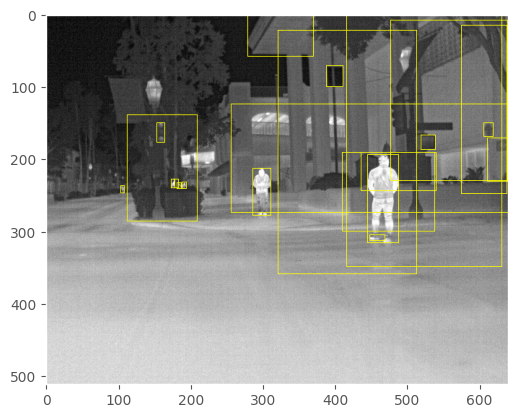

time: 297 ms (started: 2024-05-06 10:16:00 +06:00)


In [59]:


for k in boxes:
    xmin, ymin, xmax, ymax = k

    pt1 = (int(xmin), int(ymin))
    pt2 = (int(xmax), int(ymax))
    bnd_img = cv2.rectangle(img,pt1, pt2,(53,255, 0),1)
#     bnd_img = cv2.putText(
#         bnd_img,
#         str(classification_dictionary[int(predicted)]),
#         (int(xmin)-5, int(ymin)),
#         fontFace = cv2.FONT_HERSHEY_SIMPLEX,
#         fontScale = 0.3,
#         color = (0, 0, 255),
#         thickness=1)
plt.grid(False)
plt.imshow(bnd_img, cmap = 'gray')

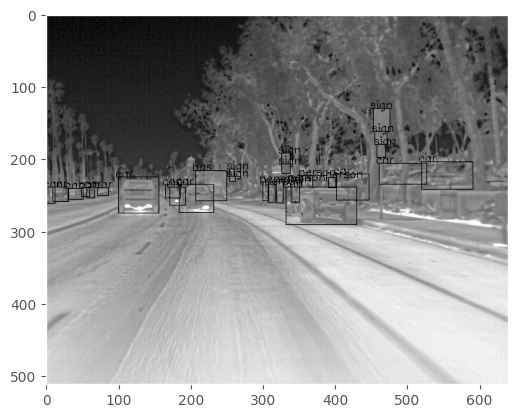

time: 234 ms (started: 2024-05-06 09:56:51 +06:00)


In [28]:
img = cv2.merge([img_gray[0],img_gray[0],img_gray[0]])
for i,j in zip(boxes, box[0]['labels']):
    xmin, ymin, xmax, ymax = i
    
    pt1 = (int(xmin), int(ymin))
    pt2 = (int(xmax), int(ymax))
    bnd_img = cv2.rectangle(img,pt1, pt2,(255,255,0),1)
    bnd_img = cv2.putText(
        bnd_img,
        str(j),
        (int(xmin), int(ymin) - 10),
        fontFace = cv2.FONT_HERSHEY_SIMPLEX,
        fontScale = 0.3,
        color = (0, 255, 255),
        thickness=1)
plt.grid(False)
plt.imshow(bnd_img, cmap = 'gray')

In [35]:
def get_model_size(ir_path, m_type: str = "Mb", verbose: bool = True) -> float:
    xml_size = os.path.getsize(ir_path)
    bin_size = os.path.getsize(os.path.splitext(ir_path)[0] + ".bin")
    for t in ["bytes", "Kb", "Mb"]:
        if m_type == t:
            break
        xml_size /= 1024
        bin_size /= 1024
    model_size = xml_size + bin_size
    if verbose:
        print(f"Model graph (xml):   {xml_size:.3f} {m_type}")
        print(f"Model weights (bin): {bin_size:.3f} {m_type}")
        print(f"Model size:          {model_size:.3f} {m_type}")
    return model_size

time: 16 ms (started: 2024-05-06 07:51:22 +06:00)


In [36]:
int8_ir_path = ".\\classifier\\quantized_model_focal.xml"
print(f"[2/7] Save INT8 model: {int8_ir_path}")
int8_model_size = get_model_size(int8_ir_path, verbose=True)

[2/7] Save INT8 model: .\classifier\quantized_model_focal.xml
Model graph (xml):   0.162 Mb
Model weights (bin): 10.694 Mb
Model size:          10.856 Mb
time: 0 ns (started: 2024-05-06 07:51:23 +06:00)


In [37]:
core = ov.Core()

model_q = core.read_model(model=int8_ir_path)
model_q = core.compile_model(model=model_q, device_name='CPU')

time: 219 ms (started: 2024-05-06 07:51:23 +06:00)


In [38]:
transform = {
        'train': torchvision.transforms.Compose([
            torchvision.transforms.Resize([64,64]), # Resizing the image as the VGG only take 224 x 244 as input size
            torchvision.transforms.RandomHorizontalFlip(), # Flip the data horizontally
            #TODO if it is needed, add the random crop
            torchvision.transforms.RandomHorizontalFlip(p=0.5),
            torchvision.transforms.ToTensor(),
#             transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ]),
        'test': torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            torchvision.transforms.Resize([64,64]),
            torchvision.transforms.ToTensor(),

#             transforms.RandomHorizontalFlip(),
        ])
    }

time: 0 ns (started: 2024-05-06 07:51:24 +06:00)


In [39]:
classification_dictionary = {0:'person', 1: 'light', 2:'hydrant', 3:'sign', 4:'bike', 5:'car', 6:'skateboard',
                            7: 'motor', 8: 'bus', 9: 'stroller', 10: 'other', 11: 'truck', 12: 'negative'}

time: 15 ms (started: 2024-05-06 07:51:24 +06:00)


In [40]:
pred = []

model.eval()
model.to('cuda')
for i in range(len(val_dataset)):
    scores = []
    predictions = []
    img3 = val_dataset[i][0]
    f = open(".\\input\\detection-results\\image_{0}.txt".format(i), "w")

    image = img3.unsqueeze(0)
    image = image.to('cuda')

    box = model(image)
    boxes = box[0]['boxes']
    boxes
    img_gray = np.float64(image.to('cpu'))
    img_gray= img_gray[0]

    img = cv2.merge([img_gray[0],img_gray[0],img_gray[0]])
    for i in boxes:
        xmin, ymin, xmax, ymax = i
        pt1 = (int(xmin), int(ymin))
        pt2 = (int(xmax), int(ymax))
    #     crop = img.permute(1, 2, 0).numpy()
        crop = img[int(ymin):int(ymax), int(xmin):int(xmax)]
        crop = transform['test'](crop)
        crop = crop.unsqueeze(0)
        output_layer = model_q.output(0)
        output = model_q(crop)[output_layer]
        output_batch = torch.from_numpy(output)
        output_batch = torch.nn.functional.softmax(output_batch)
        score, predicted = output_batch.max(1)
#         i = i.detach().cpu()
#         score = score.detach().cpu()
#         predicted = predicted.detach().cpu()
#         scores.append(score.squeeze())
#         predictions.append(predicted.squeeze())
#     preds_dict = dict()
#     preds_dict['boxes'] = boxes.detach().cpu()
#     preds_dict['scores'] = torch.Tensor(scores)
#     preds_dict['labels'] = torch.IntTensor(predictions)
#     pred.append(preds_dict)
        if predicted != 12:

            f.write(classification_dictionary[int(predicted)]+" "+str(float(score))+" "+str(float(xmin))+" "+ str(float(ymin)) +" "+ str(float(xmax)) +" "+ str(float(ymax)))
            f.write("\n")
    f.close()
# # #             bnd_img = cv2.rectangle(img,pt1, pt2,(0,255, 255),1)
# #             bnd_img = cv2.putText(
#                 bnd_img,
#                 str(classification_dictionary[int(predicted)]),
#                 (int(xmin), int(ymin) - 10),
#                 fontFace = cv2.FONT_HERSHEY_SIMPLEX,
#                 fontScale = 1,
#                 color = (0, 255, 255),
#                 thickness=1)
        
#         plt.grid(False)
#         plt.imshow(bnd_img, cmap = 'gray')

time: 1min 47s (started: 2024-05-06 07:51:25 +06:00)


In [41]:
len(pred)

0

time: 0 ns (started: 2024-05-06 07:53:13 +06:00)


In [83]:
metric = MeanAveragePrecision(iou_type="bbox")
metric.update(pred, targets)
metric_summary = metric.compute()
print(metric_summary)

{'map': tensor(0.1288), 'map_50': tensor(0.2260), 'map_75': tensor(0.1242), 'map_small': tensor(0.0832), 'map_medium': tensor(0.2725), 'map_large': tensor(0.3387), 'mar_1': tensor(0.0908), 'mar_10': tensor(0.1916), 'mar_100': tensor(0.2043), 'mar_small': tensor(0.1562), 'mar_medium': tensor(0.3196), 'mar_large': tensor(0.3630), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=torch.int32)}
time: 7.19 s (started: 2024-05-06 05:43:55 +06:00)


In [42]:
!python main.py

39.73% = bike AP 
27.78% = bus AP 
68.57% = car AP 
17.32% = hydrant AP 
40.71% = light AP 
24.10% = motor AP 
0.27% = other AP 
59.69% = person AP 
26.42% = sign AP 
0.00% = skateboard AP 
0.00% = stroller AP 
0.00% = truck AP 
mAP = 25.38%
time: 45.2 s (started: 2024-05-06 07:53:13 +06:00)


Traceback (most recent call last):
  File "D:\Downloads\FLIR_ADAS_v2\main.py", line 792, in <module>
    draw_plot_func(
  File "D:\Downloads\FLIR_ADAS_v2\main.py", line 298, in draw_plot_func
    fig.canvas.set_window_title(window_title)
AttributeError: 'FigureCanvasAgg' object has no attribute 'set_window_title'
